In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
random_seed = 69
np.random.seed(random_seed)

df = pd.read_csv('munster_hourly.csv', parse_dates=["DATUM"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATUM        35672 non-null  datetime64[ns]
 1   STATIONS_ID  35672 non-null  int64         
 2   QN_4         35672 non-null  int64         
 3   TT_TER       35672 non-null  float64       
 4   RF_TER       35672 non-null  float64       
 5   VGSL         35672 non-null  float64       
 6   TS05         35672 non-null  float64       
 7   BF10         35672 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 2.2 MB


In [42]:
reindexed_df = df.copy()
reindexed_df.DATUM = reindexed_df.DATUM.astype('datetime64[ns]')
reindexed_df = reindexed_df.groupby(pd.Grouper(key='DATUM', axis=0, freq='D', sort=True)).mean()

reindexed_df

,STATIONS_ID,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
DATUM,,,,,,,
1991-01-01,1766.0,10.0,3.900000,86.000000,0.3,2.9,102.0
1991-01-02,1766.0,10.0,9.200000,90.666667,1.4,6.3,110.0
1991-01-03,1766.0,10.0,7.733333,82.333333,1.0,6.6,110.0
1991-01-04,1766.0,10.0,6.433333,76.666667,1.2,5.5,106.0
1991-01-05,1766.0,10.0,5.466667,78.000000,1.0,3.7,109.0
...,...,...,...,...,...,...,...
2021-12-27,1766.0,1.0,3.050000,87.750000,0.1,-0.1,97.0
2021-12-28,1766.0,1.0,6.700000,92.250000,0.2,0.5,104.0
2021-12-29,1766.0,1.0,7.900000,96.250000,0.3,5.4,107.0


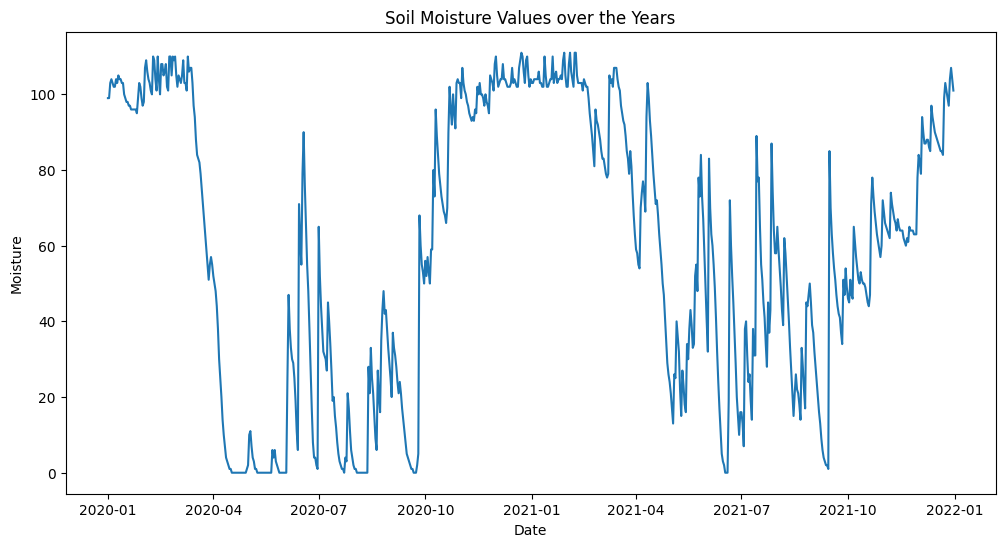

In [8]:
plt.figure(figsize=(12,6))
plt.title('Soil Moisture Values over the Years')
plt.xlabel('Date')
plt.ylabel('Moisture')
plt.plot(reindexed_df['BF10']['2020-01-01':])

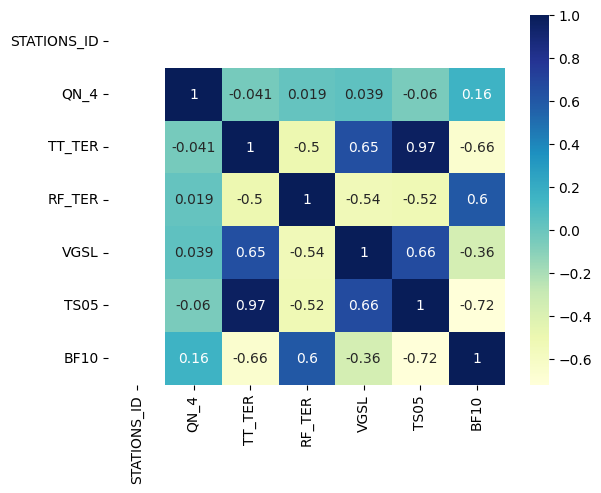

In [9]:
sns.heatmap(reindexed_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

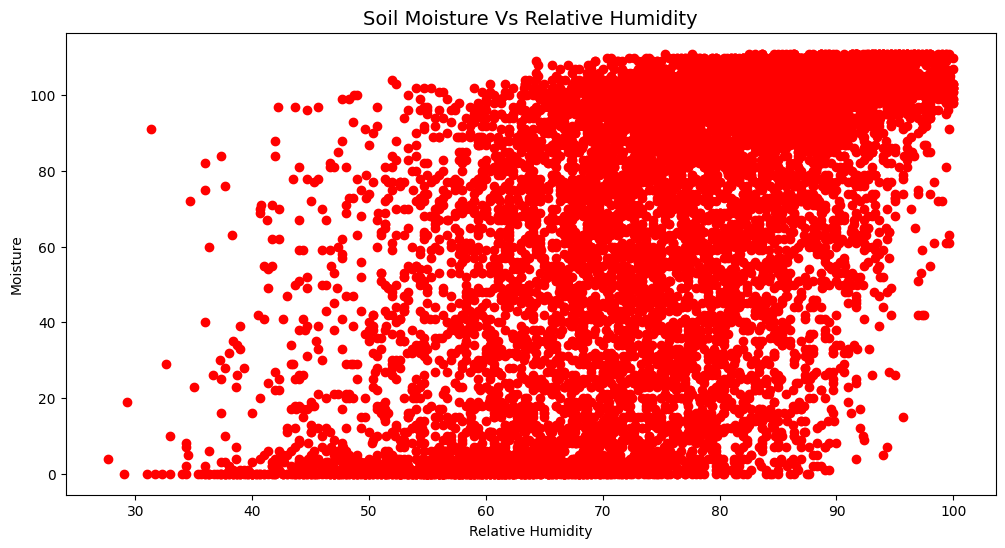

In [13]:
reindexed_df = reindexed_df[reindexed_df.RF_TER > 0]

plt.figure(figsize=(12,6))
plt.scatter(x = reindexed_df['RF_TER'], y = reindexed_df['BF10'], color='red')
plt.title('Soil Moisture Vs Relative Humidity', fontsize=14)
plt.xlabel('Relative Humidity')
plt.ylabel('Moisture')
plt.show()

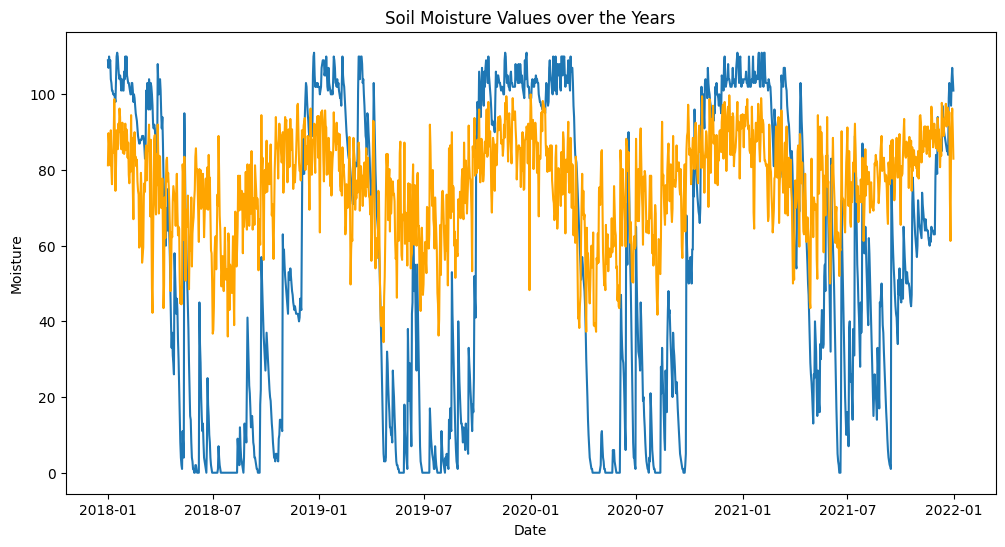

In [14]:
plt.figure(figsize=(12,6))
plt.title('Soil Moisture Values over the Years')
plt.xlabel('Date')
plt.ylabel('Moisture')
plt.plot(reindexed_df['BF10']['2018':])
plt.plot(reindexed_df['RF_TER']['2018':], c='orange')

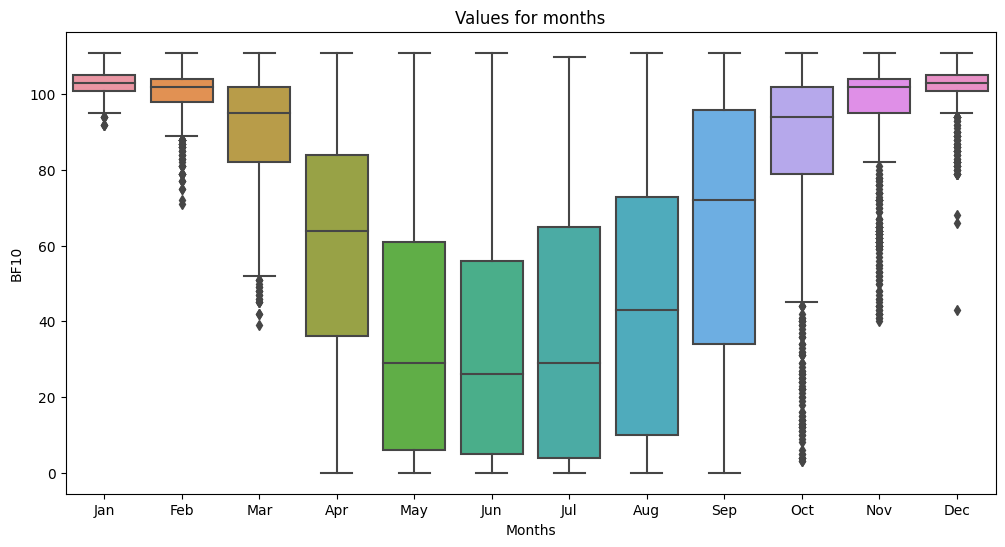

In [15]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x=reindexed_df.index.strftime("%b"), y=reindexed_df["BF10"], ax=ax)
plt.title("Values for months")
plt.xlabel("Months")
plt.show()

In [16]:
future_days = 1

df2 = reindexed_df[['BF10']]
df2['BF10-Shifted'] = reindexed_df[['BF10']].shift(-future_days)
df2

/tmp/ipykernel_690/650890343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['BF10-Shifted'] = reindexed_df[['BF10']].shift(-future_days)


,BF10,BF10-Shifted
DATUM,,
1991-01-01,102.0,110.0
1991-01-02,110.0,110.0
1991-01-03,110.0,106.0
1991-01-04,106.0,109.0
1991-01-05,109.0,103.0
...,...,...
2021-12-27,97.0,104.0
2021-12-28,104.0,107.0
2021-12-29,107.0,104.0


In [22]:
# Dropping columns we won't be using for the predictions of closing price
X = df2[['BF10-Shifted']][:-future_days].astype('int32')

# Getting just the closing price column
y = df2['BF10'][:-future_days].astype('int32')

# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2, random_state=random_seed)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=False, random_state=random_seed)

# print("", X_train.shape, "\n", y_train.shape, 
#       "\n", X_val.shape, "\n", y_val.shape,
#       "\n", X_test.shape, "\n", y_test.shape)

linear = LinearRegression().fit(X_train, y_train)

print(y_test.shape)
y_test = y_test.values.reshape(-1,1)
print(y_test.shape)

(2265,)
(2265, 1)


In [23]:
from seglearn.transform import FeatureRep, SegmentXYForecast, last

TIME_WINDOW=100
FORECAST_DISTANCE=30

X_train, X_else = train_test_split(reindexed_df[['BF10']], test_size=0.2, shuffle=False, random_state=69)
X_valid, X_test= train_test_split(X_else, test_size=0.5, shuffle=False, random_state=69)

segmenter = SegmentXYForecast(width=TIME_WINDOW, step=1, y_func=last, forecast=FORECAST_DISTANCE)

X_train_rolled, y_train_rolled,_=segmenter.fit_transform([X_train.values.flatten()],[X_train.values.flatten()])
X_valid_rolled, y_valid_rolled,_=segmenter.fit_transform([X_valid.values.flatten()],[X_valid.values.flatten()])
X_test_rolled, y_test_rolled,_=segmenter.fit_transform([X_test.values.flatten()],[X_test.values.flatten()])

X_train_rolled.shape, y_train_rolled.shape

((8928, 100), (8928,))

In [24]:
# Warning, Keras needs a 1D matrix, not a vector, so one must do:

X_train_rolled = X_train_rolled[:,:, np.newaxis]
X_valid_rolled = X_valid_rolled[:,:, np.newaxis]
X_test_rolled = X_test_rolled[:,:, np.newaxis]

## SHAPE: (samples, timesteps, variables)
print(X_train_rolled.shape)

(8928, 100, 1)


In [25]:
N_CELLS = 50
KERNEL = 'GlorotNormal'

model = Sequential()
model.add(LSTM(N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences=True, input_shape = (X_train_rolled.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS, activation='tanh', kernel_initializer=KERNEL, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = N_CELLS))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [26]:
from tensorflow.keras import backend as be

be.clear_session()

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Crate a callback for efficiency purposes
my_callback = EarlyStopping(monitor='loss',patience=3)

# Fitting the RNN to the Training set
history = model.fit(X_train_rolled, y_train_rolled,
                    epochs = 20,
                    validation_data = (X_valid_rolled,y_valid_rolled),
                    batch_size = 100,
                    shuffle = False,
                    callbacks=[my_callback])

Epoch 1/20
90/90 [==============================] - 22s 174ms/step - loss: 5531.4395 - val_loss: 3775.6316
Epoch 2/20
90/90 [==============================] - 15s 162ms/step - loss: 4707.5239 - val_loss: 3372.4968
Epoch 3/20
90/90 [==============================] - 15s 161ms/step - loss: 4224.9653 - val_loss: 3045.0225
Epoch 4/20
90/90 [==============================] - 15s 165ms/step - loss: 3805.9067 - val_loss: 2768.7134
Epoch 5/20
90/90 [==============================] - 15s 162ms/step - loss: 3449.6182 - val_loss: 2535.5925
Epoch 6/20
90/90 [==============================] - 15s 164ms/step - loss: 3132.0999 - val_loss: 2339.1147
Epoch 7/20
90/90 [==============================] - 15s 167ms/step - loss: 2851.1487 - val_loss: 2175.0303
Epoch 8/20
90/90 [==============================] - 15s 165ms/step - loss: 2617.2214 - val_loss: 2039.7135
Epoch 9/20
90/90 [==============================] - 15s 165ms/step - loss: 2412.7615 - val_loss: 1929.3600
Epoch 10/20
90/90 [==================

Maximum Loss : 5531.4395

Minimum Loss : 1432.1641

Loss difference : 4099.2754


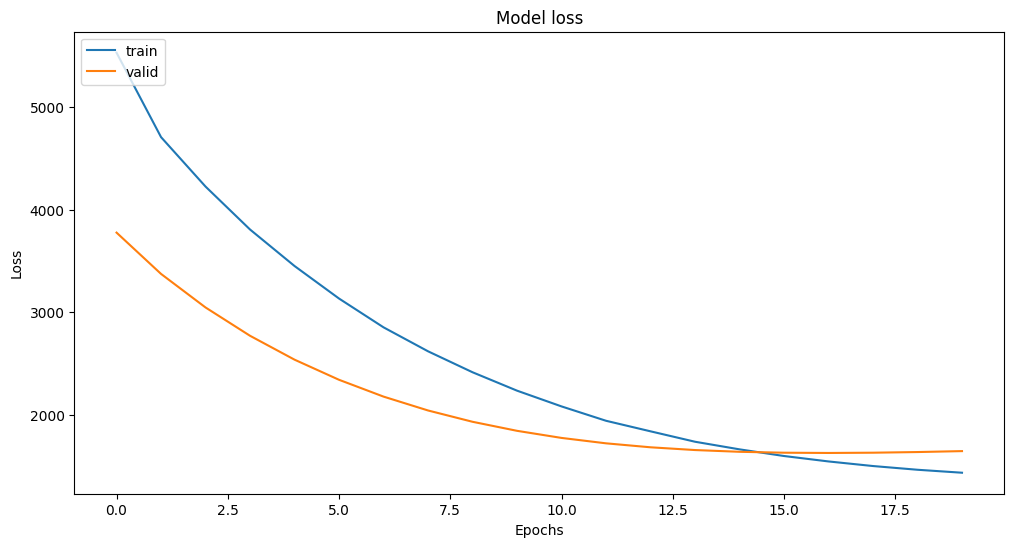

In [27]:
# Plot the accuracy and loss
plt.figure(figsize=(12,6))
plt.title('Model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'valid'], loc='upper left')

max_loss = np.max(history.history['loss'])
min_loss = np.min(history.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("")
print("Minimum Loss : {:.4f}".format(min_loss))
print("")
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

In [28]:
predictions = model.predict(y_test)
predictions

71/71 [==============================] - 1s 2ms/step


array([[2.4764514],
       [2.4764514],
       [2.4763403],
       ...,
       [2.4765525],
       [2.4767957],
       [2.4765525]], dtype=float32)

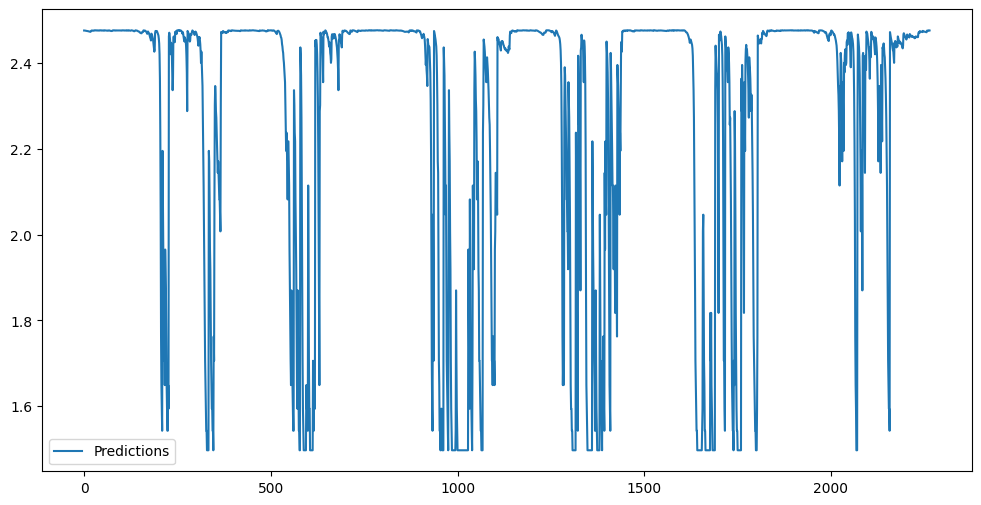

In [30]:
plt.figure(figsize=(12,6))
# plt.plot(list(y_test[100:]), label="Test")
plt.plot(list(predictions), label="Predictions")
plt.legend()
plt.show()

In [61]:
VALID_AND_TEST_SIZE = 0.1
TIME_WINDOW=90
FORECAST_DISTANCE=30

In [64]:
df2 = df.copy()
df2 = df2[['DATUM', 'BF10']]
df2 = df2.groupby(pd.Grouper(key='DATUM', axis=0, freq='D', sort=True)).mean()
df2 = df2.reset_index()

Train-test split

In [66]:
targetcol = "BF10"
targetcol_series = df2[targetcol].astype('int32')

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_else, targetcol_series_train, targetcol_series_else = train_test_split(df2, 
                                   targetcol_series, 
                                   test_size=VALID_AND_TEST_SIZE*2, 
                                   shuffle=False)
X_valid, X_test, targetcol_series_valid, targetcol_series_test = train_test_split(X_else, targetcol_series_else, test_size=0.5, shuffle=False)

In [68]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print()
print(targetcol_series_train.shape)
print(targetcol_series_valid.shape)
print(targetcol_series_test.shape)

(9058, 2)
(1132, 2)
(1133, 2)

(9058,)
(1132,)
(1133,)


### Sliding window

Fitting X and y onto the time series: 
* first X sample has to fit TIME_WINDOW at the beginning
* last y sample has to fit FORECAST_DISTANCE-1 into the future 
    > * If `FORECAST_DISTANCE == 1`, then we just take the target column, nonshifted.
    > * If `FORECAST_DISTANCE == 2`, then we just take the target column, shifted BACK by 1 (=next row's value, `shift(-1)`), etc.

In [69]:
def sliding_window_2D_from_df(df, targetcol_series, TIME_WINDOW, FORECAST_DISTANCE):
    X_df = pd.concat([df.shift(i) for i in range(1,TIME_WINDOW+1)], axis=1)\
                      .iloc[TIME_WINDOW : len(df) - FORECAST_DISTANCE + 1]
    X_df.columns = pd.MultiIndex.from_product([range(1,TIME_WINDOW+1), df.columns])
    X_df.rename_axis(["lag", "variable"], axis=1, inplace=True)

    y_series = targetcol_series.shift( -FORECAST_DISTANCE + 1 )\
                      .iloc[ TIME_WINDOW : len(df) - FORECAST_DISTANCE + 1 ]
    return X_df, y_series

In [70]:
def spot_check_sliding_window_2D(X_df, y_series, df, target_series, FORECAST_DISTANCE=1):
    TIME_WINDOW = X_df.shape[1] // df.shape[1]
    display(X_df.head(1).iloc[:,[*list(range(2*df.shape[1])), *list(range(-2*df.shape[1],0))]])
    print("The following should be the first two lagged values:")
    display(df.iloc[:TIME_WINDOW].tail(2))
    print("The following should be the last two lagged values:")
    display(df.head(2))

    print(f"\nThe target (FORECAST_DISTANCE={FORECAST_DISTANCE}):")
    display(y_series.iloc[:10].to_frame().T)
    print(f"The actual values from the end of the first time window (TIME_WINDOW={TIME_WINDOW}):")
    display(target_series.iloc[TIME_WINDOW:].iloc[:FORECAST_DISTANCE+9].to_frame().T)

In [71]:
X_df_train, y_train = sliding_window_2D_from_df(X_train, targetcol_series_train, TIME_WINDOW, FORECAST_DISTANCE)
X_df_valid, y_valid = sliding_window_2D_from_df(X_valid, targetcol_series_valid, TIME_WINDOW, FORECAST_DISTANCE)
X_df_test, y_test = sliding_window_2D_from_df(X_test, targetcol_series_test, TIME_WINDOW, FORECAST_DISTANCE)

In [72]:
## check, just to be on the safe side...

assert y_train.notna().all()
assert y_valid.notna().all()
assert y_test.notna().all()

assert X_train.notna().all().all()
assert X_valid.notna().all().all()
assert X_test.notna().all().all()

Spot-checking...

In [73]:
spot_check_sliding_window_2D(X_df_train, y_train, X_train, targetcol_series_train, FORECAST_DISTANCE)

lag              1                2                89                90       
variable      DATUM  BF10      DATUM  BF10      DATUM   BF10      DATUM   BF10
90       1991-03-31  63.0 1991-03-30  65.0 1991-01-02  110.0 1991-01-01  102.0

The following should be the first two lagged values:


,DATUM,BF10
88,1991-03-30,65.0
89,1991-03-31,63.0


The following should be the last two lagged values:


,DATUM,BF10
0,1991-01-01,102.0
1,1991-01-02,110.0



The target (FORECAST_DISTANCE=30):


,90,91,92,93,94,95,96,97,98,99
BF10,20.0,18.0,28.0,53.0,47.0,42.0,38.0,34.0,28.0,29.0


The actual values from the end of the first time window (TIME_WINDOW=90):


,90,91,92,93,94,95,96,97,98,99,...,119,120,121,122,123,124,125,126,127,128
BF10,61,57,55,51,46,43,45,41,37,32,...,20,18,28,53,47,42,38,34,28,29


### Sliding window into (samples, timesteps, variables) shaped array


In [74]:
## where we are at...: something we can feed into generic models (e.g., feedfwd NN's, sklearn models like RF...)
X_df_train

lag              1                 2                 3                 4   \
variable      DATUM   BF10      DATUM   BF10      DATUM   BF10      DATUM   
90       1991-03-31   63.0 1991-03-30   65.0 1991-03-29   68.0 1991-03-28   
91       1991-04-01   61.0 1991-03-31   63.0 1991-03-30   65.0 1991-03-29   
92       1991-04-02   57.0 1991-04-01   61.0 1991-03-31   63.0 1991-03-30   
93       1991-04-03   55.0 1991-04-02   57.0 1991-04-01   61.0 1991-03-31   
94       1991-04-04   51.0 1991-04-03   55.0 1991-04-02   57.0 1991-04-01   
...             ...    ...        ...    ...        ...    ...        ...   
9024     2015-09-15  104.0 2015-09-14  104.0 2015-09-13  102.0 2015-09-12   
9025     2015-09-16  109.0 2015-09-15  104.0 2015-09-14  104.0 2015-09-13   
9026     2015-09-17  107.0 2015-09-16  109.0 2015-09-15  104.0 2015-09-14   
9027     2015-09-18  103.0 2015-09-17  107.0 2015-09-16  109.0 2015-09-15   
9028     2015-09-19  110.0 2015-09-18  103.0 2015-09-17  107.0 2015-09-16   

lag                     5          ...         86                87         \
variable   BF10      DATUM   BF10  ...      DATUM   BF10      DATUM   BF10   
90         71.0 1991-03-27   75.0  ... 1991-01-05  109.0 1991-01-04  106.0   
91         68.0 1991-03-28   71.0  ... 1991-01-06  103.0 1991-01-05  109.0   
92         65.0 1991-03-29   68.0  ... 1991-01-07  103.0 1991-01-06  103.0   
93         63.0 1991-03-30   65.0  ... 1991-01-08  110.0 1991-01-07  103.0   
94         61.0 1991-03-31   63.0  ... 1991-01-09  107.0 1991-01-08  110.0   
...         ...        ...    ...  ...        ...    ...        ...    ...   
9024      104.0 2015-09-11   88.0  ... 2015-06-22   31.0 2015-06-21   12.0   
9025      102.0 2015-09-12  104.0  ... 2015-06-23   26.0 2015-06-22   31.0   
9026      104.0 2015-09-13  102.0  ... 2015-06-24   20.0 2015-06-23   26.0   
9027      104.0 2015-09-14  104.0  ... 2015-06-25   13.0 2015-06-24   20.0   
9028      109.0 2015-09-15  104.0  ... 2015-06-26    7.0 2015-06-25   13.0   

lag              88                89                90         
variable      DATUM   BF10      DATUM   BF10      DATUM   BF10  
90       1991-01-03  110.0 1991-01-02  110.0 1991-01-01  102.0  
91       1991-01-04  106.0 1991-01-03  110.0 1991-01-02  110.0  
92       1991-01-05  109.0 1991-01-04  106.0 1991-01-03  110.0  
93       1991-01-06  103.0 1991-01-05  109.0 1991-01-04  106.0  
94       1991-01-07  103.0 1991-01-06  103.0 1991-01-05  109.0  
...             ...    ...        ...    ...        ...    ...  
9024     2015-06-20    1.0 2015-06-19    1.0 2015-06-18    0.0  
9025     2015-06-21   12.0 2015-06-20    1.0 2015-06-19    1.0  
9026     2015-06-22   31.0 2015-06-21   12.0 2015-06-20    1.0  
9027     2015-06-23   26.0 2015-06-22   31.0 2015-06-21   12.0  
9028     2015-06-24   20.0 2015-06-23   26.0 2015-06-22   31.0  

[8939 rows x 180 columns]

In [75]:
def rolled_X_from_2D_sliding_window_df(X_df, timesteps):
    X_rolled = X_df.values.reshape(X_df.shape[0], timesteps, -1)
    return X_rolled

In [76]:
X_rolled_train = rolled_X_from_2D_sliding_window_df(X_df_train, TIME_WINDOW)
X_rolled_valid = rolled_X_from_2D_sliding_window_df(X_df_valid, TIME_WINDOW)
X_rolled_test = rolled_X_from_2D_sliding_window_df(X_df_test, TIME_WINDOW)

In [77]:
print(y_train.shape)
print(X_df_train.shape)
print(X_rolled_train.shape)

print()

print(y_test.shape)
print(X_df_test.shape)
print(X_rolled_test.shape)

(8939,)
(8939, 180)
(8939, 90, 2)

(1014,)
(1014, 180)
(1014, 90, 2)


Automated checking of first samples...

In [78]:
def autocheck_first_sample(orig_df, X_rolled, targetcol_series, y):
    np.testing.assert_equal(orig_df[:TIME_WINDOW].iloc[::-1].values,
                            X_rolled[0])
    np.testing.assert_equal(pd.Series(targetcol_series).iloc[TIME_WINDOW-1+FORECAST_DISTANCE],
                            pd.Series(y).iloc[0])

In [79]:
autocheck_first_sample(X_train, X_rolled_train, targetcol_series_train, y_train)
autocheck_first_sample(X_valid, X_rolled_valid, targetcol_series_valid, y_valid)
autocheck_first_sample(X_test, X_rolled_test, targetcol_series_test, y_test)

Spot checking...

In [80]:
def spot_check_3D_Xarray(X_rolled, X_df):
    for sample_idx in [0, 1, -2, -1]:
        print(f"SAMPLE NR. {sample_idx}:")
        print("In derived and in rolled data, for time steps 0,1,...-2,-1:")
        display( X_df.iloc[[sample_idx], [0, 1, 2, 3, -4,-3, -2, -1]].round(4) )
        print(X_rolled[sample_idx][0].round(4), X_rolled[sample_idx][1].round(4), 
            "...",  X_rolled[sample_idx][-2].round(4),  X_rolled[sample_idx][-1].round(4))
        print("\n")

In [82]:
X_rolled_train[0][-1].round(4)

TypeError: unsupported operand type(s) for *: 'Timestamp' and 'float'

In [83]:
spot_check_3D_Xarray(X_rolled_train, X_df_train)

SAMPLE NR. 0:
In derived and in rolled data, for time steps 0,1,...-2,-1:


lag              1                2                89                90       
variable      DATUM  BF10      DATUM  BF10      DATUM   BF10      DATUM   BF10
90       1991-03-31  63.0 1991-03-30  65.0 1991-01-02  110.0 1991-01-01  102.0

TypeError: unsupported operand type(s) for *: 'Timestamp' and 'float'

## Building LSTM networks

In [85]:
## Quick data prep that is intuitively a good starting point

VALID_AND_TEST_SIZE = 0.1
TIME_WINDOW=100
FORECAST_DISTANCE=30

targetcol = "BF10"
targetcol_series = df2[targetcol]

## train valid test split
X_train, X_else, targetcol_series_train, targetcol_series_else = train_test_split(df2[["BF10"]], 
                                   targetcol_series, 
                                   test_size=VALID_AND_TEST_SIZE*2, 
                                   shuffle=False)
X_valid, X_test, targetcol_series_valid, targetcol_series_test = train_test_split(X_else, targetcol_series_else, test_size=0.5, shuffle=False)

## sliding window
X_df_train, y_train = sliding_window_2D_from_df(X_train, targetcol_series_train, TIME_WINDOW, FORECAST_DISTANCE)
X_df_valid, y_valid = sliding_window_2D_from_df(X_valid, targetcol_series_valid, TIME_WINDOW, FORECAST_DISTANCE)
X_df_test, y_test = sliding_window_2D_from_df(X_test, targetcol_series_test, TIME_WINDOW, FORECAST_DISTANCE)

## for lstm
X_rolled_train = rolled_X_from_2D_sliding_window_df(X_df_train, TIME_WINDOW)
X_rolled_valid = rolled_X_from_2D_sliding_window_df(X_df_valid, TIME_WINDOW)
X_rolled_test = rolled_X_from_2D_sliding_window_df(X_df_test, TIME_WINDOW)

autocheck_first_sample(X_train, X_rolled_train, targetcol_series_train, y_train)
autocheck_first_sample(X_valid, X_rolled_valid, targetcol_series_valid, y_valid)
autocheck_first_sample(X_test, X_rolled_test, targetcol_series_test, y_test)

print(X_rolled_train.shape)

(8929, 100, 1)


###### Aside: About the LSTM layer in keras: return_sequences vs. return_state

In [87]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras import backend as be
import tensorflow as tf

## we use 10 samples
## and 4 units (hidden state is 4-long for each time step)

tf.random.set_seed(42)
be.clear_session()
input_layer = X_rolled_train[:10]

whole_seq_output, final_memory_state, final_carry_state =  LSTM(4, return_sequences=True, return_state=True)(input_layer)

tf.random.set_seed(42)
be.clear_session()
whole_seq_output2 =  LSTM(4, return_sequences=True, return_state=False)(input_layer)

tf.random.set_seed(42)
be.clear_session()
out_last =  LSTM(4, return_sequences=False, return_state=False)(input_layer)

tf.random.set_seed(42)
be.clear_session()
whole_seq_output3, final_memory_state3, final_carry_state3 =  LSTM(4, return_sequences=False, return_state=True)(input_layer)


print("return_sequences=True, return_state=True")
print(whole_seq_output.shape)
print(final_memory_state.shape)
print(final_carry_state.shape)

print()
print("return_sequences=True, return_state=False")
print(whole_seq_output2.shape)

print()
print("return_sequences=False, return_state=False")
print(out_last.shape)

print()
print("return_sequences=False, return_state=True")
print(whole_seq_output3.shape)
print(final_memory_state3.shape)
print(final_carry_state3.shape)



return_sequences=True, return_state=True
(10, 100, 4)
(10, 4)
(10, 4)

return_sequences=True, return_state=False
(10, 100, 4)

return_sequences=False, return_state=False
(10, 4)

return_sequences=False, return_state=True
(10, 4)
(10, 4)
(10, 4)


In [88]:
print("For first sample...\n")
print("\treturn_sequences=True, return_state=True")
print("\tlast two time step hidden state output:", np.array(whole_seq_output[0][-2:]))
print("\tfinal hidden state (=output):", np.array(final_memory_state[0]))
print("\tfinal cell state:", np.array(final_carry_state[0]))

print()
print("\treturn_sequences=True, return_state=False")
print("\tlast two time step hidden state output:", np.array(whole_seq_output2[0][-2:]))

print()
print("\treturn_sequences=False, return_state=False")
print("\tfinal hidden state (=output):", np.array(out_last[0]))

print()
print("\treturn_sequences=False, return_state=True")
print("\thidden state:", np.array(whole_seq_output3[0]))
print("\tfinal hidden state (=output):", np.array(final_memory_state3[0]))
print("\tfinal cell state:", np.array(final_carry_state3[0]))



For first sample...

	return_sequences=True, return_state=True
	last two time step hidden state output: [[ 3.0552590e-01 -3.7987732e-21 -1.0764520e-24  4.9220332e-28]
 [ 3.0583715e-01 -1.0160822e-19 -5.8381791e-23  4.6696483e-26]]
	final hidden state (=output): [ 3.0583715e-01 -1.0160822e-19 -5.8381791e-23  4.6696483e-26]
	final cell state: [ 3.1594661e-01 -1.0160822e-19 -9.9610406e-01  1.0000000e+00]

	return_sequences=True, return_state=False
	last two time step hidden state output: [[ 8.1322901e-03 -8.1984758e-27 -9.2473744e-07  7.1247292e-01]
 [ 1.1742973e-02 -6.5027022e-25 -2.5116397e-06  7.0134467e-01]]

	return_sequences=False, return_state=False
	final hidden state (=output): [-7.6159418e-01  7.5510247e-24  1.0000000e+00 -8.8789874e-01]

	return_sequences=False, return_state=True
	hidden state: [-1.1681332e-10  8.2378990e-23 -7.6557815e-01 -9.9167055e-01]
	final hidden state (=output): [-1.1681332e-10  8.2378990e-23 -7.6557815e-01 -9.9167055e-01]
	final cell state: [-1.0000000e

###### Model definition

In [89]:
#---- Hyperparams and settings ----

EPOCHS = 30
BATCH_SIZE = 200
LEARNING_RATE = 1
LSTM_CELL_SIZE = 300
LSTM_CELL_SIZE2 = 100

In [90]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## number of input variables: the final dimension in the 3D prepared data (index 2)
column_count=X_rolled_train.shape[2]

be.clear_session()

model = Sequential()

### !!!return_sequences=True if recurrent layer follows
model.add( LSTM(LSTM_CELL_SIZE, return_sequences=True, input_shape=(TIME_WINDOW,column_count)))

### default return_sequences=False if Dense layer follows
model.add( LSTM(LSTM_CELL_SIZE2) )

### the output layer:
model.add(  Dense(1) )  ## Question: what is the activation here?

optimizer = Adam(learning_rate=LEARNING_RATE)

## remember, we're doing regression, so choose loss (and output layer) accordingly!
model.compile(loss='mean_squared_error', optimizer=optimizer)

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 300)          362400    
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 522,901
Trainable params: 522,901
Non-trainable params: 0
_________________________________________________________________
None


In [91]:
history = model.fit(x=X_rolled_train,
                    y=y_train, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_rolled_valid,y_valid), 
                    epochs=10,
                    verbose=1, 
                    shuffle=False,
                    )

Epoch 1/10
45/45 [==============================] - 30s 588ms/step - loss: 1448.3016 - val_loss: 2122.1462
Epoch 2/10
45/45 [==============================] - 26s 579ms/step - loss: 1361.6506 - val_loss: 2271.0212
Epoch 3/10
45/45 [==============================] - 26s 587ms/step - loss: 1367.4125 - val_loss: 2267.3672
Epoch 4/10
45/45 [==============================] - 26s 585ms/step - loss: 1367.9640 - val_loss: 2267.2305
Epoch 5/10
45/45 [==============================] - 26s 587ms/step - loss: 1368.5936 - val_loss: 2267.7437
Epoch 6/10
45/45 [==============================] - 28s 614ms/step - loss: 1368.9558 - val_loss: 2267.9438
Epoch 7/10
45/45 [==============================] - 28s 615ms/step - loss: 1369.1857 - val_loss: 2268.0608
Epoch 8/10
45/45 [==============================] - 27s 596ms/step - loss: 1369.3455 - val_loss: 2268.1375
Epoch 9/10
45/45 [==============================] - 27s 607ms/step - loss: 1369.4617 - val_loss: 2268.1912
Epoch 10/10
45/45 [==================

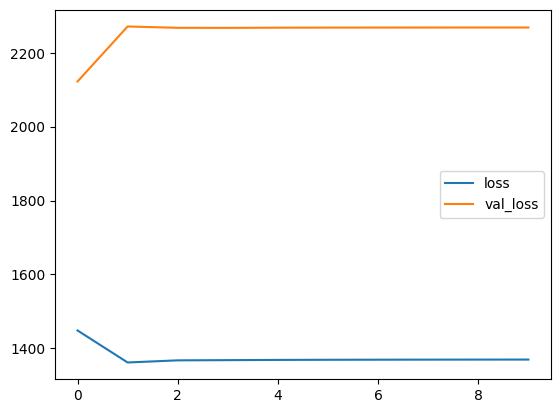

In [92]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [93]:
predictions = model.predict(X_rolled_test).flatten()

32/32 [==============================] - 13s 181ms/step


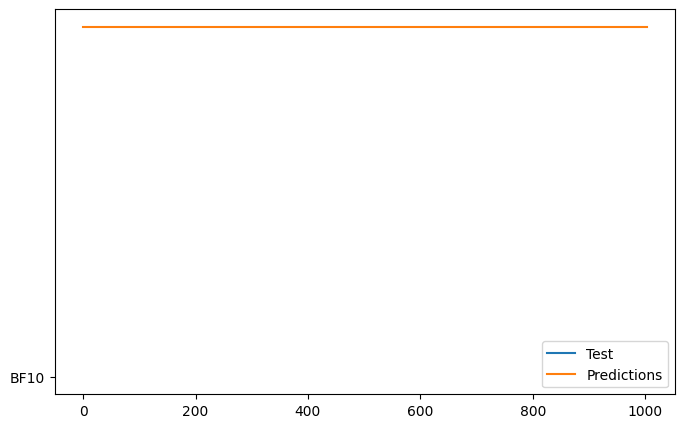

In [94]:
plt.figure(figsize=(8,5))
plt.plot(list(X_rolled_test[TIME_WINDOW:]), label="Test")
plt.plot(list(predictions), label="Predictions")
plt.legend()
plt.show()

In [ ]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')
        
check_stationarity(df2)

The series is stationary


/tmp/ipykernel_321/2753353209.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  analysis = seasonal_decompose(df2['2020'], model='additive', extrapolate_trend=12)


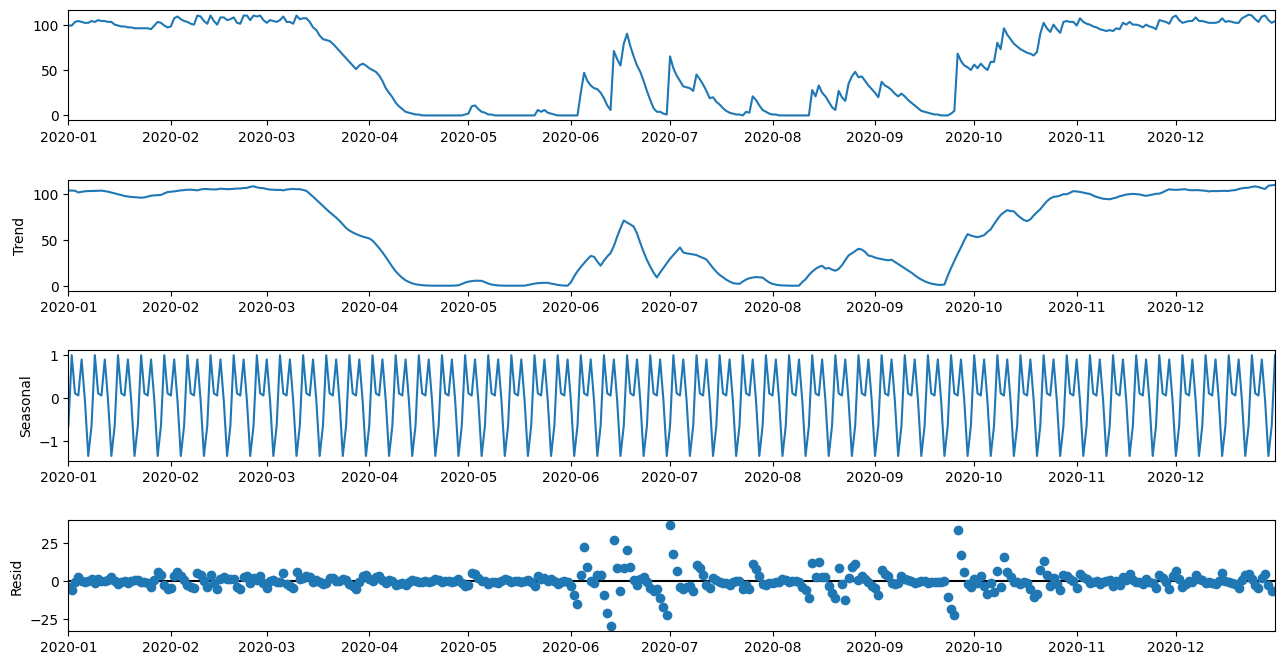

In [ ]:
analysis = seasonal_decompose(df2['2020'], model='additive', extrapolate_trend=12)
    
fig = analysis.plot()
fig.set_size_inches(14, 7)
plt.show()